


>**Out of the 14 clinical data features, we used only features which have less missing values,as input to the model.The features we used are BMI>30, Tobacco, Age at CT, FRS 10-year risk (%), and Met Sx.**




In [153]:
# KM estimate library
!pip install lifelines;


In [154]:
# Library for under sampling
!pip install imblearn

In [155]:
# Packages for under sampling
from imblearn import under_sampling,over_sampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [156]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [157]:
# Read the excel file
import pandas as pd
df1=pd.read_excel("/content/OppScrData (1).xlsx")
df1;

Death prediction is a class, this class is mainily used for statistical analysis and for imputing the NAN values in the death column. 
This class has the following methods

1.   Status column - Creates a status column. This is column has binary values 1 or 0. 1 represents the living subject and 0 - dead subject
2.   Clinical data - converts the categorical columns to numeric columns. 
3. Health score - create a column Health_score and and sums all the columns in clinical data.
4. new_health_score - this creates a new column  new_health_score. This is used for reducing the health score range to -1 to 1
5. UnderSample - for undersampling the data. In the code we used Random_state=0.
6.estimation_death_date - This method is used to impute the NAN values in the death column. 



In [158]:
class Death_Prediction():
  def __init__(self,data):
     self.data=data
     self.X_UnderSampled=None
     self.y_Undersampled=None
     self.data_dead_subjects=None
  # created a new binary value column name "status" , to tell if the subject is alive(1) or not(0)
  def StatusColumn(self):
    self.data['status']=self.data['DEATH [d from CT]']
    self.data['status']=self.data['status'].mask((self.data['status']>0),0)
    self.data['status']=self.data['status'].fillna(1)
  def print_data(self):
    return(self.data)
  
  def Clinical_data(self): 
    df1=self.data
    df1['Tobacco']=df1['Tobacco'].replace(['Yes'],-1)
    df1['Tobacco']=df1['Tobacco'].replace(['No'],1)
    df1['Tobacco']=df1['Tobacco'].fillna(0)
    df1['BMI >30']=df1['BMI >30'].replace(['Y'],-1)
    df1['BMI >30']=df1['BMI >30'].replace(['N'],1)
    df1['BMI >30']=df1['BMI >30'].fillna(0)
    df1['Met Sx']=df1['Met Sx'].replace(['Y'],-1)
    df1['Met Sx']=df1['Met Sx'].replace(['N'],1)
    df1['Met Sx']=df1['Met Sx'].fillna(0)
    df1['FRS 10-year risk (%)']=df1['FRS 10-year risk (%)'].replace(['<1%'],1) # No risk
    df1['FRS 10-year risk (%)']=df1['FRS 10-year risk (%)'].replace(['>30%'],-1) # risk
    df1['FRS 10-year risk (%)']=df1['FRS 10-year risk (%)'].replace(['X'],0)# No risk
    df1['FRS 10-year risk (%)']=df1['FRS 10-year risk (%)'].mask((df1['FRS 10-year risk (%)']>0) & (df1['FRS 10-year risk (%)']<=0.1),1)
    df1['FRS 10-year risk (%)']=df1['FRS 10-year risk (%)'].mask((df1['FRS 10-year risk (%)']>=0.2) & (df1['FRS 10-year risk (%)']<1),0.25)
    df1['FRS 10-year risk (%)']=df1['FRS 10-year risk (%)'].mask((df1['FRS 10-year risk (%)']>0.10) & (df1['FRS 10-year risk (%)']<0.2),0.5)
    self.data=df1
  # Calculate the health score of subjects 
  def Health_score(self):
    df=self.data
    features=['Tobacco','BMI >30','Met Sx','FRS 10-year risk (%)']
    df=df.loc[:,features]
    Health_score=np.sum(df,axis=1)
    self.data['Health_score']=Health_score
  # since the data is unbalanced we do up sampling 


  def data_dead(self):
    self.data_dead_subjects=p1.X_UnderSampled[p1.X_UnderSampled['status']==0]
  
  def new_health_score(self):
    df=self.data
    df['new_health_score']=df['Health_score']
    df['new_health_score']=df['new_health_score'].mask((df['new_health_score']>=-4) & (df['new_health_score']<=0.25),-1)
    df['new_health_score']=df['new_health_score'].mask((df['new_health_score']>0.25) & (df['new_health_score']<=2),0)
    df['new_health_score']=df['new_health_score'].mask((df['new_health_score']>2) ,1)
    self.data=df

  def UnderSample(self):
    df=self.data
    X=df.iloc[:,0:self.data.shape[1]]
    y=df['status']
    rus=RandomUnderSampler(random_state=0) # same sequence of samples will be generated
    X_resampled,y_resampled=rus.fit_resample(X,y)
    print(sorted(Counter(y_resampled).items()),y_resampled.shape)
    #print(X_resampled,y_resampled)
    self.X_UnderSampled=X_resampled
    self.y_Undersampled=y_resampled
  
  def estimation_death_date(self):
    X_resampled=self.X_UnderSampled
    X_resampled['DEATH [d from CT]']=X_resampled['DEATH [d from CT]'].fillna(0)
    a=X_resampled['DEATH [d from CT]']
    for i in range(0,len(X_resampled['DEATH [d from CT]'])):
      if ((X_resampled['DEATH [d from CT]'][i]==0) & (X_resampled['new_health_score'][i]==1)):
            a[i]=np.abs(77-X_resampled['Age at CT'][i])*365
      if ((X_resampled['DEATH [d from CT]'][i]==0) & (X_resampled['new_health_score'][i]==-1)):
            a[i]=np.abs(68-X_resampled['Age at CT'][i])*365

      if ((X_resampled['DEATH [d from CT]'][i]==0) & (X_resampled['new_health_score'][i]==0)):
            a[i]=np.abs(70-X_resampled['Age at CT'][i])*365
      X_resampled["new_Death[d from CT]"]=a
    self.X_UnderSampled["DEATH [d from CT]"]=a
    #print(X_resampled["new_Death[d from CT]"])
    

Kaplan Meier estimate is a popular survival analysis model. This model estimates the amount of time/duration taken for one event to occur.

This class has the following methods. 


1.   estimation_curve - plots the histograms for the death column
2.   KM_model_all - This method is used to fit all the data.
3.   predict - This method takes predicted probability of survival as input and outputs the estimated days left after the CT.



In [159]:
class km_estimate():
  def __init__(self,data,dead_subjects_data):
    self.Under_sampled_data=data                     # Under sampled data
    self.dead_subjects_data=dead_subjects_data       # dead subjects data
    self.T = None
    self.E=None
    self.kmf=None

  def estimation_curve(self):
    T = self.T
    E = self.E
    plt.hist(T, bins = 50)
    plt.xlabel("no.of days lived after CT")
    plt.ylabel("Count of subjects")
    plt.title("Histogram of dead subjects")
    plt.show()
  def KM_model_all(self):
    self.T=self.Under_sampled_data["DEATH [d from CT]"]
    self.E=self.Under_sampled_data["status"]
    kmf = KaplanMeierFitter()
    kmf.fit(durations = self.T, event_observed = self.E)
    plt.hist(self.T, bins = 50)
    plt.xlabel("no.of days lived after CT")
    plt.ylabel("Count of subjects")
    plt.title("Histogram of dead subjects")
    plt.show()
    print(kmf.plot_survival_function())                #
    self.kmf=kmf
  def predict(self,y_prob):
    y_predict=self.kmf.percentile(y_prob)
    return(y_predict)

Training_CT_Data class is used for standardizing the data : split the data into train_test _split. And also to separate the important features. 

In [160]:
class Training_CT_Data():
  def __init__(self,df):
    self.df=df.iloc[:,41:51]
    self.df['status']=df['status']
    self.df['Death']=df['DEATH [d from CT]']
    self.df['BMI']=df['BMI >30']
    self.df['age']=df['Age at CT']
    self.df['Tobacco']=df['Tobacco']
    self.df['FRS']=df['FRS 10-year risk (%)']
    self.df['Met-sy']=df['Met Sx']
    self.df=self.df.dropna()
    self.X=None
    self.y=None
  def important_features_ML(self):
    names=['L1_HU_BMD','VAT Area (cm2)','VAT/SAT     Ratio','Muscle HU','AoCa        Agatston','Death']
    features=['L1_HU_BMD','VAT Area (cm2)','VAT/SAT     Ratio','Muscle HU','AoCa        Agatston','Death','BMI','age','Tobacco','FRS']
    label=['status']
    df1=self.df
    #df1=df1.loc[:,names]
    y=df1[label]
    X=df1.loc[:,features]
    self.X=X
    self.y=y
  def standard_scalar(self):
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.25,stratify=self.y,random_state=42)
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    return(X_train_scaled,X_test_scaled,y_train,y_test,X_train,X_test)

  def print_value(self):
    return(self.y) 

Logistic Regression

In [161]:
from sklearn.linear_model import LogisticRegression
def lr(X_train_scaled,X_test_scaled,y_train,y_test):
  clf = LogisticRegression()
  clf.fit(X_train_scaled,y_train)
  y_pred=clf.predict(X_test_scaled)
  y_test_prob=clf.predict_proba(X_test_scaled)[:,0]
  y_train_prob=clf.predict_proba(X_train_scaled)[:,0]
  print(classification_report(y_test, y_pred))
  return(y_train_prob,y_test_prob)
  #return(y_train_prob,y_test_prob)


Naive Bayes

In [162]:
from sklearn.naive_bayes import GaussianNB
def NB(X_train_scaled,X_test_scaled,y_train,y_test):
  clf = GaussianNB()
  clf.fit(X_train_scaled,y_train)
  y_pred=clf.predict(X_test_scaled)
  y_test_prob=clf.predict_proba(X_test_scaled)[:,0]
  y_train_prob=clf.predict_proba(X_train_scaled)[:,0]
  print(classification_report(y_test, y_pred))
  return(y_train_prob,y_test_prob)

Decison tree

In [163]:
from sklearn import tree
def dt(X_train_scaled,X_test_scaled,y_train,y_test):
  
  
  clf = tree.DecisionTreeClassifier()
  clf.fit(X_train_scaled,y_train)
  y_pred=clf.predict(X_test_scaled)
  y_test_prob=clf.predict_proba(X_test_scaled)[:,0]
  y_train_prob=clf.predict_proba(X_train_scaled)[:,0]
  print(classification_report(y_test, y_pred))
  return(y_train_prob,y_test_prob)

Approach

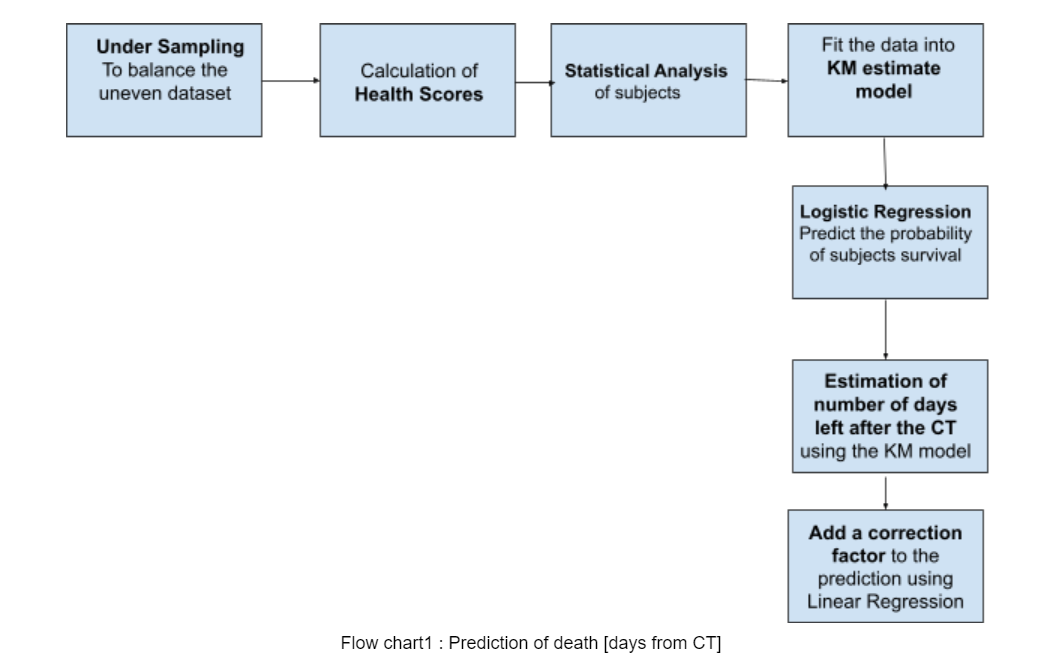

The following code uses all the above defined classes and follows the steps from undersampling to fitting all the data into the KM estimate model.



[(0.0, 549), (1.0, 549)] (1098,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


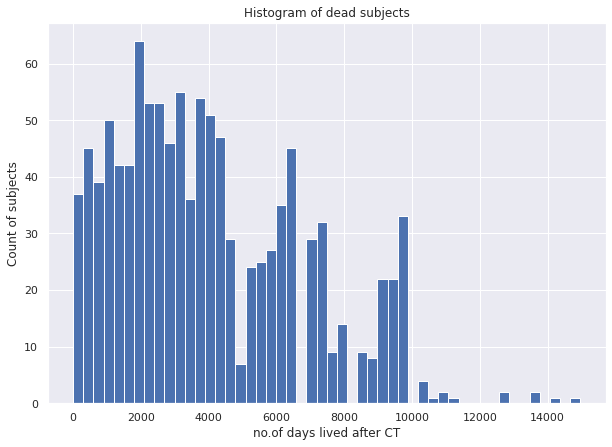

AxesSubplot(0.125,0.125;0.775x0.755)


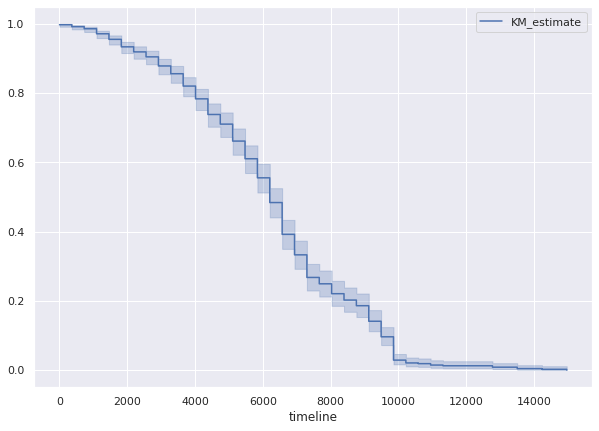

In [164]:
p1=Death_Prediction(df1) # give input data to the class
p1.StatusColumn()        # create a status column
p1.Clinical_data()       # define health scores
p1.Health_score()        # calculate the score 
p1.new_health_score()    # reduce the range of health score and calculate the new health score
p1.UnderSample()         # under sampling the data
p1.data_dead()          # data of only dead subjects
#p1.print_data()
p1.estimation_death_date() # estimation the death date of living subjects from statisctical analysis

df=p1.data
df_Under_Sampled=p1.X_UnderSampled
df_dead=p1.data_dead_subjects
#p1.y_Undersampled

p2=km_estimate(p1.X_UnderSampled,p1.data_dead_subjects)
p2.KM_model_all()


Once the data is fit, the next step is to predict the probability of survival using Logistic regression. Give these probabilitis as input to the KM estimate model for estimating the number of day remaining.

#Results and Analysis

####Statistical analysis

Health score:

We defined a new column named "Heath_scores". The health score of subject is decided based on four columns in the data. These four columns are BMI>30, Tobacco, FRS 10-year risk %, Met_sy. The subject is scored -1 or 1 based on the values in each column. This means that if the subject is very healthy, then the score is 4, and if the subject is very unhealthy then it is -4. There can be values in between -4, 4 depending on column values. The following are the criterias for the subject's health score.



---

| Column Name| Condition | Score |
| --- | --- | --- |
|BMI >=30           | >30 | -1 |
|   |<30  |  1 |
|           |NAN|1|
|Tobacco|"Yes"|-1|
||"No"|1|
||NAN|0|
|FRS 10-year risk|% below 10|1|
||10%-20%|0.5|
||>20%|-1|
||NAN|0|
|Met_Syn|"Y"|-1|
||"N"|1|




Text(0.5, 0, 'health scores')

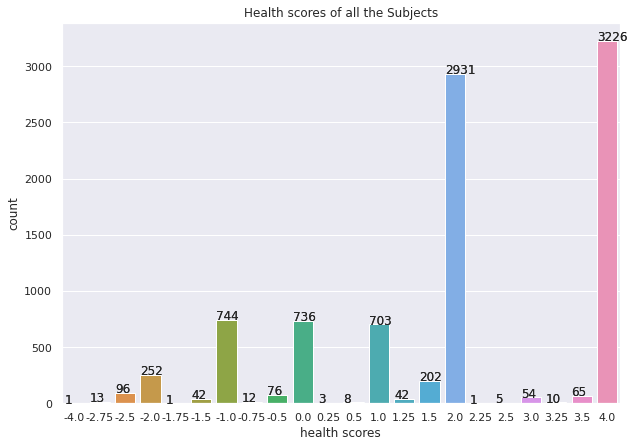

In [165]:

from IPython.core.pylabtools import figsize
from matplotlib.pyplot import xlabel
import seaborn as sns 
sns.set_theme(style='darkgrid')
figsize(10,7)
ax=sns.countplot(x='Health_score',data=df,linewidth=1)
sns.countplot(x='Health_score',data=df,linewidth=1).set(title='Health scores of all the Subjects')
for p in ax.patches:
 ax.annotate('{:d}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))

xlabel("health scores")



####Health Score count for dead subjects

Text(0.5, 0, 'health scores')

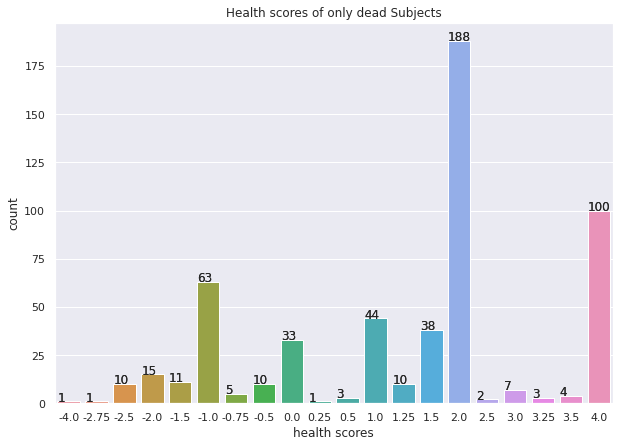

In [166]:
df_dead=df_Under_Sampled[df_Under_Sampled['status']==0]


ax1=sns.countplot(x="Health_score",data=df_dead)
sns.countplot(x='Health_score',data=df_dead,linewidth=1).set(title='Health scores of only dead Subjects')
for p in ax1.patches:
   ax1.annotate('{:d}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))
xlabel("health scores")





> The distribution of the dead subjects in each health score is uneven. So to infer anything from this distribution doesnot make sense. Hence the idea is to reduce the range of health scores such that distribution of these subjects become a bit even





New health score 

count of subjects in each health score group: new_health_score
-1.0    150
 0.0    283
 1.0    116
Name: new_health_score, dtype: int64


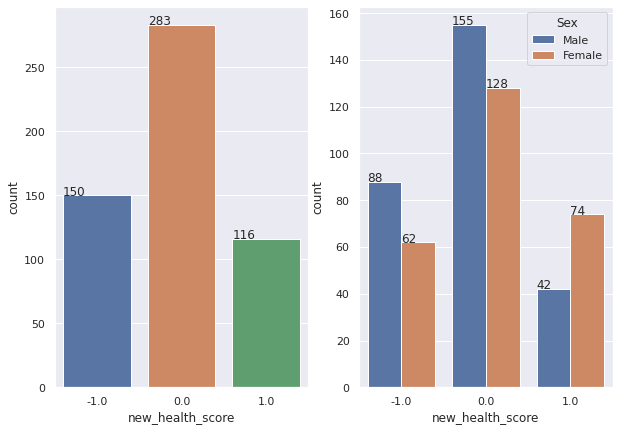

In [167]:
sns.set()
fig, axes = plt.subplots(1, 2)
sns.set_theme(style='darkgrid')
print("count of subjects in each health score group:",df_dead.groupby(['new_health_score'])['new_health_score'].count())
ax=sns.countplot(x="new_health_score",data=df_dead,ax=axes[0])
for p in ax.patches:
   ax.annotate('{:d}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))
ax=sns.countplot(x="new_health_score",hue='Sex',data=df_dead,ax=axes[1])
for p in ax.patches:
   ax.annotate('{:d}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))

In [168]:
df_dead["Current_Age"]=df_dead['Age at CT']+(df_dead['DEATH [d from CT]']/365);
df_dead.groupby(['new_health_score','Sex'])['Current_Age'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


new_health_score  Sex   
-1.0              Female    68.353336
                  Male      70.337080
 0.0              Female    70.879152
                  Male      70.822908
 1.0              Female    77.167197
                  Male      71.230398
Name: Current_Age, dtype: float64



> The dead subjects were divided based on health scores and then grouped by gender. The mean life span of the subjects were calculated using the formula.


|  |
|---|
|lifespan of the dead subject = Age at CT + (Death [d from CT]/365)|


> We see that the mean lifespans of a healthy subjects is more than the unhealthly, normal subjects. Therefore we assume that the alive subjects with similar health scores, gender have same lifespan. Using this assumption the death[d from CT] of the alive subjects can be calculated and imputed inplace of NAN value.
















#### Kaplan Meier estimate

Kaplan Meier estimate is a popular survival analysis model. This model estimates the amount of time/duration taken for one event to occur. 
 
This model takes two inputs: the first input is duration which is the death [d from CT] and the second one is event_observed which is the status of the person. The model outputs a probability curve. In other words, for a given probability of survival of the subject, the model can predict the number of days remaining after the CT.

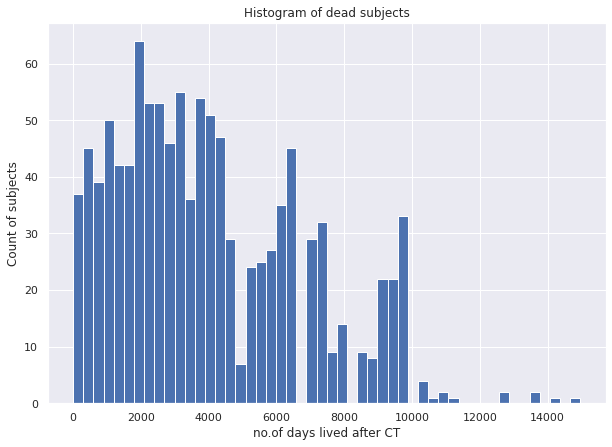

AxesSubplot(0.125,0.125;0.775x0.755)


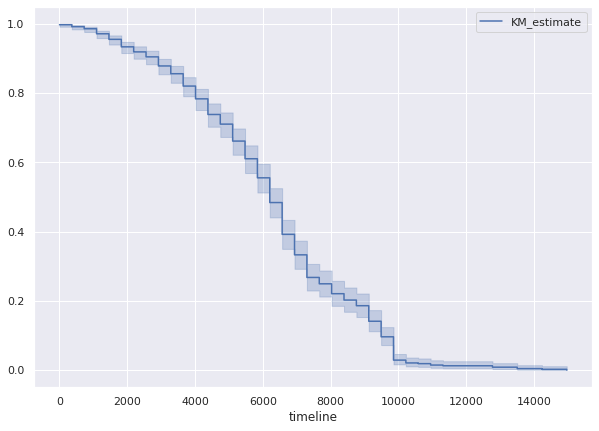

In [169]:
p2=km_estimate(p1.X_UnderSampled,p1.data_dead_subjects)
p2.KM_model_all()



> The first plot is the histogram of all the subjects with respect to death[d from CT] column . X axis shows no days remaining after the CT. y axis is the count of the subjects. 




> The second plot is the KM survival plot, for a given probability of survival the model estimates the no of days remaining after the CT.







####Logistic Regression plots

This is a plot between predicted death[d from CT] and true value death[d from CT] in training dataset. 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:273: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  exceptions.ApproximationWarning,


              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80       126
         1.0       0.82      0.77      0.80       134

    accuracy                           0.80       260
   macro avg       0.80      0.80      0.80       260
weighted avg       0.80      0.80      0.80       260



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training data')

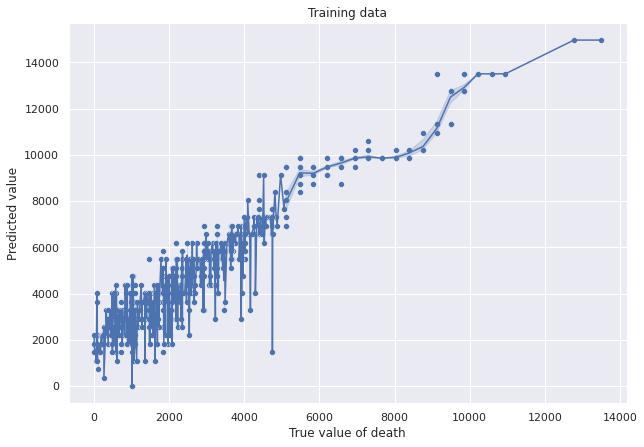

In [170]:

p3=Training_CT_Data(p1.X_UnderSampled)
p3.print_value()
p3.important_features_ML()
X_train_scaled,X_test_scaled,y_train,y_test,X_train,X_test=p3.standard_scalar()
y_train_prob,y_test_prob=lr(X_train_scaled,X_test_scaled,y_train,y_test)
y_train_pred=p2.predict(y_train_prob)
y_test_pred=p2.predict(y_test_prob)
y_train_days=[0]*len(y_train_pred)
for i in range (len(y_train_pred)):
  y_train_days[i]=y_train_pred.iloc[i,0]

y_test_days=[0]*len(y_test_pred)
for i in range (len(y_test_pred)):
  y_test_days[i]=y_test_pred.iloc[i,0]

p=sns.scatterplot(X_train['Death'],y_train_days)
p=sns.lineplot(X_train['Death'],y_train_days)
p.set_xlabel("True value of death")
p.set_ylabel("Predicted value")
p.set_title("Training data")

In [171]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(X_train['Death'],y_train_days,squared=False)
print("The rmse value between the predicted death, and the true value on the train data is:",rt)

The rmse value between the predicted death, and the true value on the train data is: 2592.8444212968493






> We see that the predictions are either over estimated or under estimated. For example for a true value of 2000, the predictions lie from 1000- 5000 range and so on for other values.The rmse value is 2592.5




Plots in test dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test data')

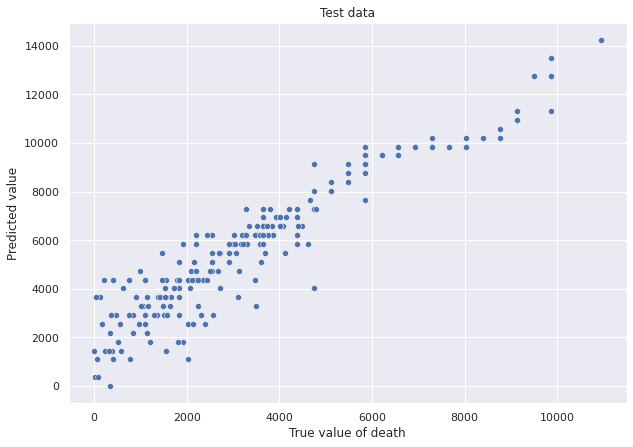

In [172]:
p=sns.scatterplot(X_test['Death'],y_test_days)
p.set_xlabel("True value of death")
p.set_ylabel("Predicted value")
p.set_title("Test data")

In [173]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(X_test['Death'],y_test_days,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 2610.0225780043183


Linear Regression plots

Since in the logistic regression, we see that the values are either over estimated/ under estimated, we feel that adding a correction factor might reduce the errors or the range of error. 

[2018.18955285]
[[1.10077115]]


Text(0.5, 1.0, 'Prediction on train data')

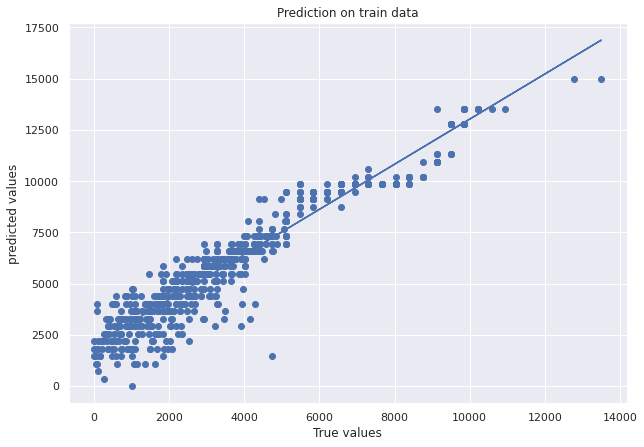

In [174]:

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
a=np.array(X_train['Death']).reshape(-1, 1)
b=np.array(y_train_days).reshape(-1, 1)
regressor.fit(a,b)
print(regressor.intercept_)
print(regressor.coef_)
c=regressor.coef_*a+regressor.intercept_
plt.scatter(a,b)
plt.plot(a,regressor.coef_*a+regressor.intercept_)
plt.xlabel("True values")
plt.ylabel("predicted values")
plt.title("Prediction on train data")

In [175]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(a,c,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 2448.4210545994792




> After using Linear regrssion, the values are still over estimated. RMSE value is 2449.73, this value is lower than the RMSE found using just logistic regression . And the range of errors are bit improved. 


Text(0.5, 1.0, 'Prediction on test data')

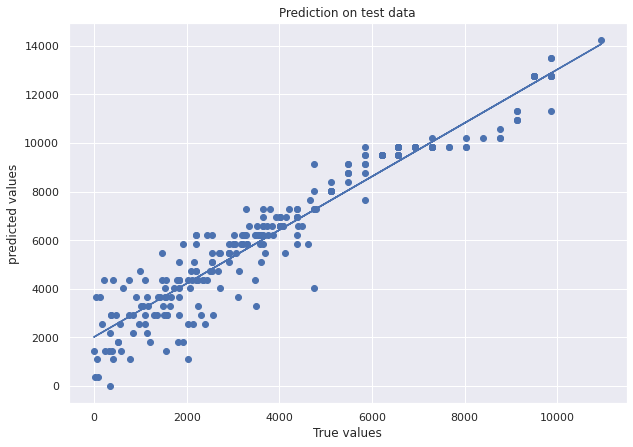

In [176]:

a=np.array(X_test['Death']).reshape(-1, 1)
b=np.array(y_test_days).reshape(-1, 1)
c=regressor.predict(a)
plt.scatter(a,b)
plt.plot(a,c)
plt.xlabel("True values")
plt.ylabel("predicted values")
plt.title("Prediction on test data")

In [177]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(a,c,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 2432.4591838044544


pedicted values on the test data are also over estimated. 

Naive Bayes

              precision    recall  f1-score   support

         0.0       0.78      0.72      0.75       126
         1.0       0.76      0.81      0.78       134

    accuracy                           0.77       260
   macro avg       0.77      0.77      0.77       260
weighted avg       0.77      0.77      0.77       260



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:273: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  exceptions.ApproximationWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args:

Text(0.5, 1.0, 'Training data')

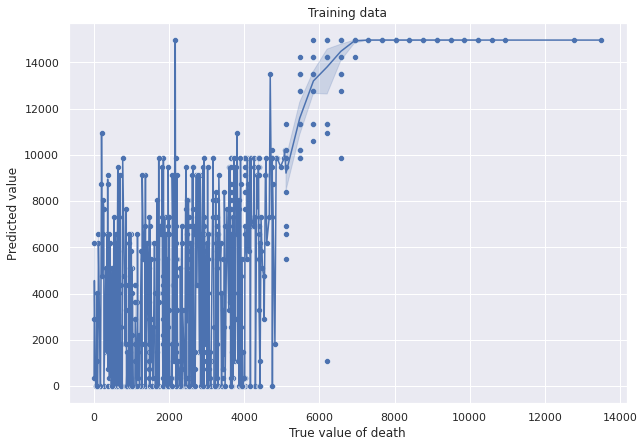

In [178]:

p3=Training_CT_Data(p1.X_UnderSampled)
p3.print_value()
p3.important_features_ML()
X_train_scaled,X_test_scaled,y_train,y_test,X_train,X_test=p3.standard_scalar()
y_train_prob,y_test_prob=NB(X_train_scaled,X_test_scaled,y_train,y_test)
y_train_pred=p2.predict(y_train_prob)
y_test_pred=p2.predict(y_test_prob)
y_train_days=[0]*len(y_train_pred)
for i in range (len(y_train_pred)):
  y_train_days[i]=y_train_pred.iloc[i,0]

y_test_days=[0]*len(y_test_pred)
for i in range (len(y_test_pred)):
  y_test_days[i]=y_test_pred.iloc[i,0]

p=sns.scatterplot(X_train['Death'],y_train_days)
p=sns.lineplot(X_train['Death'],y_train_days)
p.set_xlabel("True value of death")
p.set_ylabel("Predicted value")
p.set_title("Training data")

In [179]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(X_train['Death'],y_train_days,squared=False)
print("The rmse value between the predicted death, and the true value on the train data is:",rt)

The rmse value between the predicted death, and the true value on the train data is: 5030.15247331151


Plots for test dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test data')

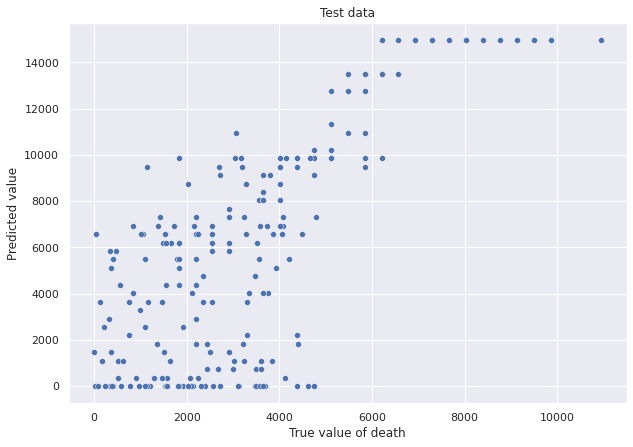

In [180]:
p=sns.scatterplot(X_test['Death'],y_test_days)

p.set_xlabel("True value of death")
p.set_ylabel("Predicted value")
p.set_title("Test data")

In [181]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(X_test['Death'],y_test_days,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 4895.73877036881


Linear Regression plots


[692.73959936]
[[1.66345022]]


Text(0.5, 1.0, 'Prediction on train data')

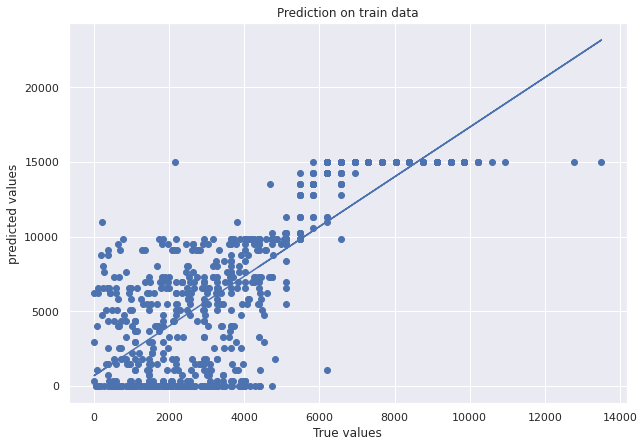

In [182]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
a=np.array(X_train['Death']).reshape(-1, 1)
b=np.array(y_train_days).reshape(-1, 1)
regressor.fit(a,b)
print(regressor.intercept_)
print(regressor.coef_)
c=regressor.coef_*a+regressor.intercept_
plt.scatter(a,b)
plt.plot(a,regressor.coef_*a+regressor.intercept_)
plt.xlabel("True values")
plt.ylabel("predicted values")
plt.title("Prediction on train data")

In [183]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(a,c,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 3872.935776900536


Text(0.5, 1.0, 'Prediction on test data')

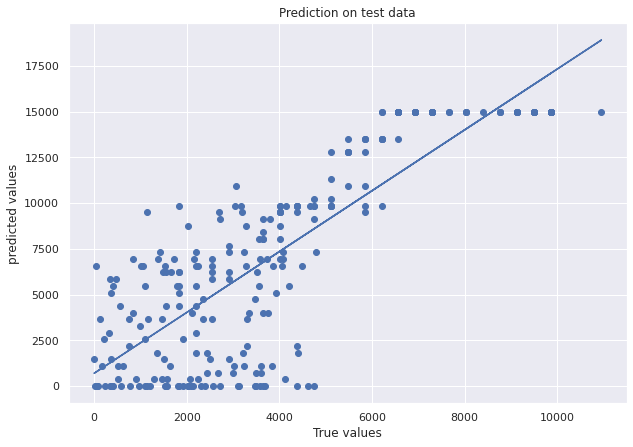

In [184]:

a=np.array(X_test['Death']).reshape(-1, 1)
b=np.array(y_test_days).reshape(-1, 1)
c=regressor.predict(a)
plt.scatter(a,b)
plt.plot(a,c)
plt.xlabel("True values")
plt.ylabel("predicted values")
plt.title("Prediction on test data")

In [185]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(a,c,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 3761.054816562451


              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85       126
         1.0       0.87      0.84      0.86       134

    accuracy                           0.85       260
   macro avg       0.85      0.85      0.85       260
weighted avg       0.85      0.85      0.85       260



/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:273: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  exceptions.ApproximationWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training data')

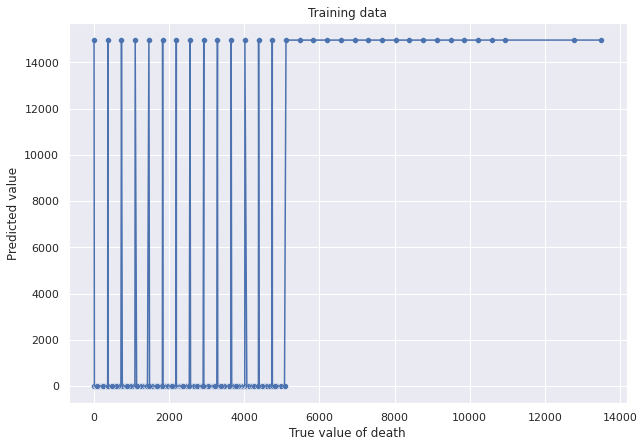

In [186]:
p3=Training_CT_Data(p1.X_UnderSampled)
p3.print_value()
p3.important_features_ML()
X_train_scaled,X_test_scaled,y_train,y_test,X_train,X_test=p3.standard_scalar()
y_train_prob,y_test_prob=dt(X_train_scaled,X_test_scaled,y_train,y_test)
y_train_pred=p2.predict(y_train_prob)
y_test_pred=p2.predict(y_test_prob)
y_train_days=[0]*len(y_train_pred)
for i in range (len(y_train_pred)):
  y_train_days[i]=y_train_pred.iloc[i,0]

y_test_days=[0]*len(y_test_pred)
for i in range (len(y_test_pred)):
  y_test_days[i]=y_test_pred.iloc[i,0]

p=sns.scatterplot(X_train['Death'],y_train_days)
p=sns.lineplot(X_train['Death'],y_train_days)
p.set_xlabel("True value of death")
p.set_ylabel("Predicted value")
p.set_title("Training data")

In [187]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(X_train['Death'],y_train_days,squared=False)
print("The rmse value between the predicted death, and the true value on the train data is:",rt)

The rmse value between the predicted death, and the true value on the train data is: 7126.207546433937




> Decision tree has a better F1 score compared to other two models. 


> The RMSE value is very high compared to other two models. This can be because of the probabilities of survival rates closer to 0 or 1. 


> These type of probabilities are not suitable to predict the death[d from CT] using KM estimate mode







Plots in test dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test data')

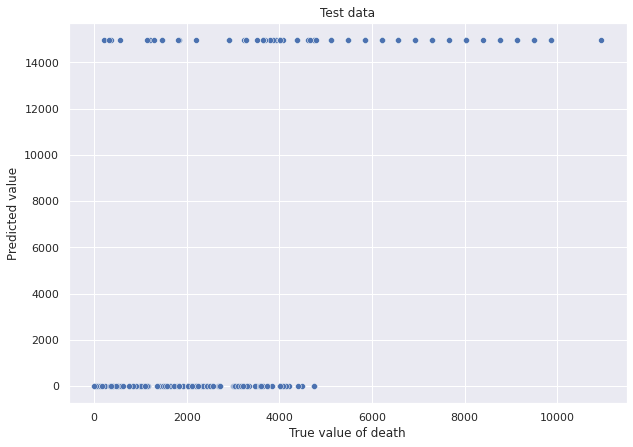

In [188]:
p=sns.scatterplot(X_test['Death'],y_test_days)

p.set_xlabel("True value of death")
p.set_ylabel("Predicted value")
p.set_title("Test data")

In [189]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(X_test['Death'],y_test_days,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 6980.97852905142


[635.89255765]
[[1.72680149]]


Text(0.5, 1.0, 'Prediction on train data')

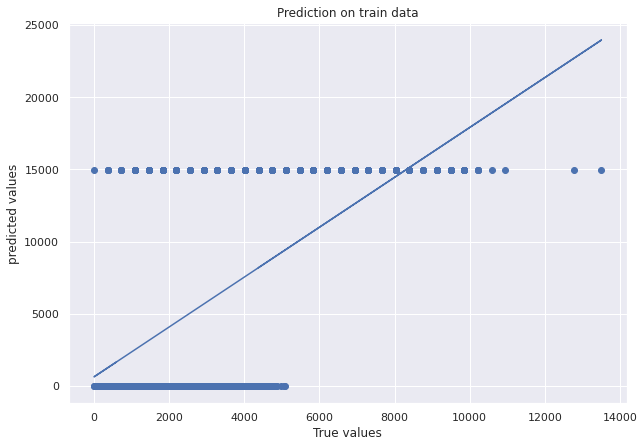

In [190]:

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
a=np.array(X_train['Death']).reshape(-1, 1)
b=np.array(y_train_days).reshape(-1, 1)
regressor.fit(a,b)
print(regressor.intercept_)
print(regressor.coef_)
c=regressor.coef_*a+regressor.intercept_
plt.scatter(a,b)
plt.plot(a,regressor.coef_*a+regressor.intercept_)
plt.xlabel("True values")
plt.ylabel("predicted values")
plt.title("Prediction on train data")

In [191]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(a,c,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 4134.442278281929


Text(0.5, 1.0, 'Prediction on test data')

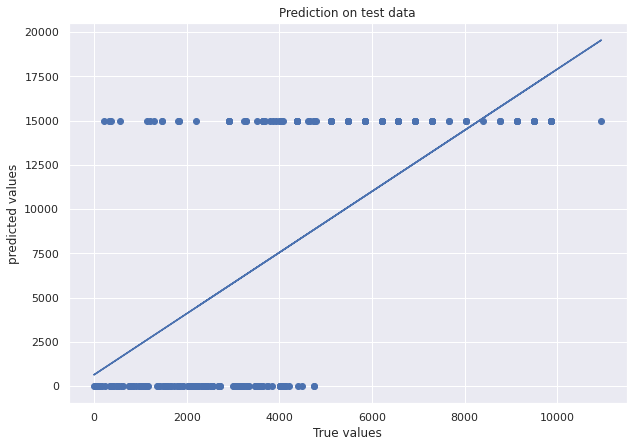

In [192]:

a=np.array(X_test['Death']).reshape(-1, 1)
b=np.array(y_test_days).reshape(-1, 1)
c=regressor.predict(a)
plt.scatter(a,b)
plt.plot(a,c)
plt.xlabel("True values")
plt.ylabel("predicted values")
plt.title("Prediction on test data")

In [193]:
from sklearn.metrics import mean_squared_error
rt=mean_squared_error(a,c,squared=False)
print("The rmse value between the predicted death, and the true value on the test data is:",rt)

The rmse value between the predicted death, and the true value on the test data is: 4011.9329461556717


Conclusion


1.   Using Clinical data along with CT as input to the model didnot make much difference in the performance or prediction.
2.   There is a slight increase or decrease in the RMSE values between with clinical data and without.



# Future Works

1. Find a better way of of estimating the days from CT, 
i.e. change the way of imputing the NAN values in the death column. 
2. Try over sampling, instead of under sampling
3. Using a polynomial regression curve instead of Linear Regression, for adding the correction factor